# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
import syft as sy

device = torch.device('cpu')
# training on GPU in not awailable right now

torch.manual_seed(1)

In [1]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128, transform=None):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.transform = transform

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image = self.dataframe['image'][idx]
        label = self.dataframe['labels'][idx]

        image = Image.open(image).convert("L")

        if self.reshape:
            image = image.resize((self.height,self.width))

        array = np.asarray(image)
        if self.transform:
            array = self.transform(array)
        
        array = array.reshape(1, self.height,self.width)
        image = torch.tensor(array)
        label = torch.tensor(label)

        return [image,label]

    def __repr__(self):
        return str(self.dataframe.head())


NameError: name 'Dataset' is not defined

In [3]:
color_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.4),
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(brightness=0.6),
        transforms.ColorJitter(brightness=0.7)
    ]),
    transforms.ToTensor()
])

rotation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=30),
        transforms.RandomRotation(degrees=25),
        transforms.RandomRotation(degrees=20),
        transforms.RandomRotation(degrees=15)
    ]),
    transforms.ToTensor()
])

flip_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1)
        ])
    ]),
    transforms.ToTensor()
])

grayscale_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=.1, p=1)
    ]),
    transforms.ToTensor()
])

In [4]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64, transform=None) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=rotation_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=flip_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=grayscale_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=color_transformations)
print(dataset)

1012, 253
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


<ipython-input-2-8fce9ac9f1d5>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


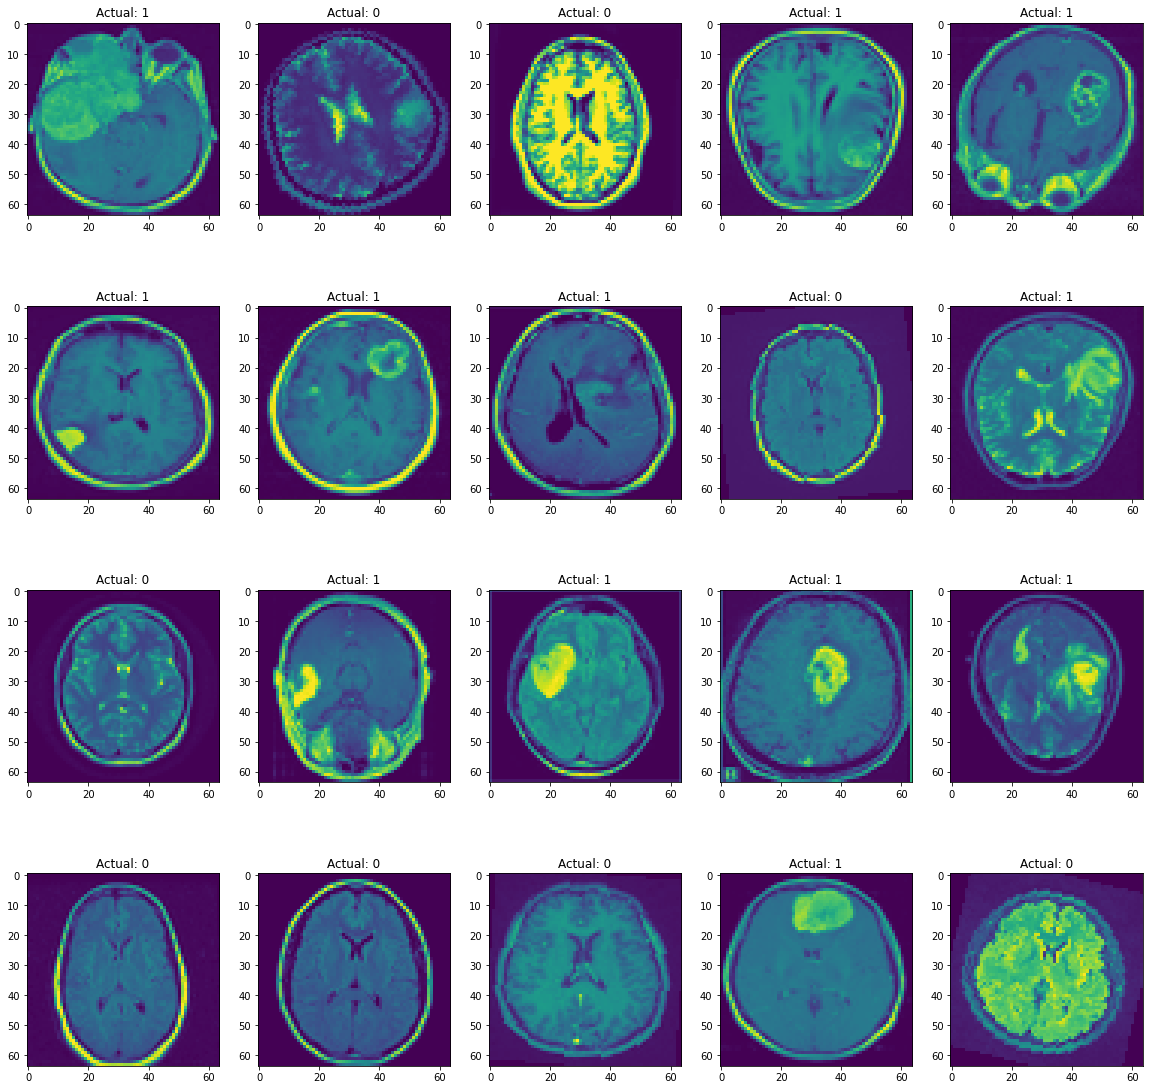

In [5]:
datasetsize = len(dataset)
train_size = int(datasetsize * 0.8)
test_size = datasetsize - train_size

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"{len(train_data)}, {len(test_data)}")


fig = plt.figure(figsize=(20,20))
for i in range(20):
    target = train_data[i][1]
    plt.subplot(4,5, i+1)
    print(train_data[i][0].shape)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Actual: {target}')
plt.show()


In [8]:
type(train_data)

torch.utils.data.dataset.Subset

#### MODEL with SyMPC wraper

In [7]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        # print(x.shape)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        # print(x.shape)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        # print(x.shape)
        x = self.linear2(x)
        # print(x.shape)
        x = self.flat(x)
        # print(x.shape)
        x = self.linear3(x)
        # print(x.shape)

        return x

In [8]:
model = BrainTumorModel(torch_ref=torch)
print(model)

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 800
plot = False

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss += loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss/number_of_imags, accuracy/number_of_imags


def train(model, train_data, test_data, num_epochs = 100, batch_size = 32):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
            i+=1
            break
        if epoch%10 == 0:
            test_loss, accuracy = test(model, test_loader, loss_fn)
            print(f'Epochs: {epoch} Loss: {total_loss/i: .4f}, Accuracy: {accuracy: .4f}')
#             print('-----------------------------------------------')
        loss_list.append(total_loss/batch_size)
    return loss_list

In [10]:
loss_list_dumb = train(model, train_data, test_data, num_epochs=num_epochs)

<ipython-input-2-8fce9ac9f1d5>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Epochs: 0 Loss:  0.6226, Accuracy:  0.6612
Epochs: 10 Loss:  0.5693, Accuracy:  0.7003
Epochs: 20 Loss:  0.5379, Accuracy:  0.7081
Epochs: 30 Loss:  0.6485, Accuracy:  0.6964
Epochs: 40 Loss:  0.5766, Accuracy:  0.7085
Epochs: 50 Loss:  0.6338, Accuracy:  0.7085
Epochs: 60 Loss:  0.5973, Accuracy:  0.7007
Epochs: 70 Loss:  0.5617, Accuracy:  0.7523
Epochs: 80 Loss:  0.5069, Accuracy:  0.7085
Epochs: 90 Loss:  0.5355, Accuracy:  0.7202
Epochs: 100 Loss:  0.5639, Accuracy:  0.7241
Epochs: 110 Loss:  0.6084, Accuracy:  0.7957
Epochs: 120 Loss:  0.5121, Accuracy:  0.7800
Epochs: 130 Loss:  0.5389, Accuracy:  0.7632
Epochs: 140 Loss:  0.5553, Accuracy:  0.7202
Epochs: 150 Loss:  0.4992, Accuracy:  0.7359
Epochs: 160 Loss:  0.5436, Accuracy:  0.7827
Epochs: 170 Loss:  0.4301, Accuracy:  0.8031
Epochs: 180 Loss:  0.4495, Accuracy:  0.7597
Epochs: 190 Loss:  0.4364, Accuracy:  0.8078
Epochs: 200 Loss:  0.3917, Accuracy:  0.7953
Epochs: 210 Loss:  0.5329, Accuracy:  0.7918
Epochs: 220 Loss:  0.

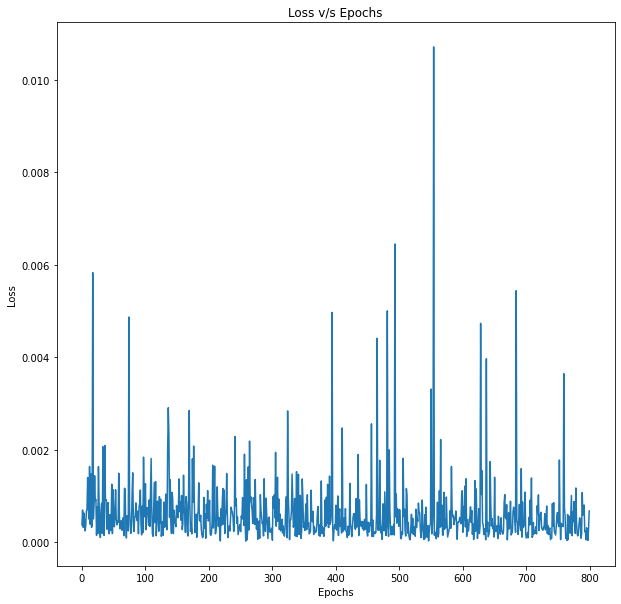

In [42]:
# loss_list = train(model, train_data, test_data, num_epochs=num_epochs)

loss_list = [loss_item.detach() for loss_item in loss_list_dumb]
plot = True
if plot:
    fig = plt.figure(figsize=(10,10))
    plt.plot(list(range(num_epochs)),loss_list)
    plt.title("Loss v/s Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [43]:
#Evaluate model

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss +=loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
    print(f'Test Accuracy: {accuracy/number_of_imags:.2f} \n'
          f'Test Loss: {test_loss/len(image): .2f}')
    return test_loss, accuracy

test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
test(model, test_loader, loss_fn)

<ipython-input-2-2ae5f95b70be>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Test Accuracy: 0.78 
Test Loss:  237.05


(237.04625085970503, tensor(59.))

<ipython-input-2-8fce9ac9f1d5>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])


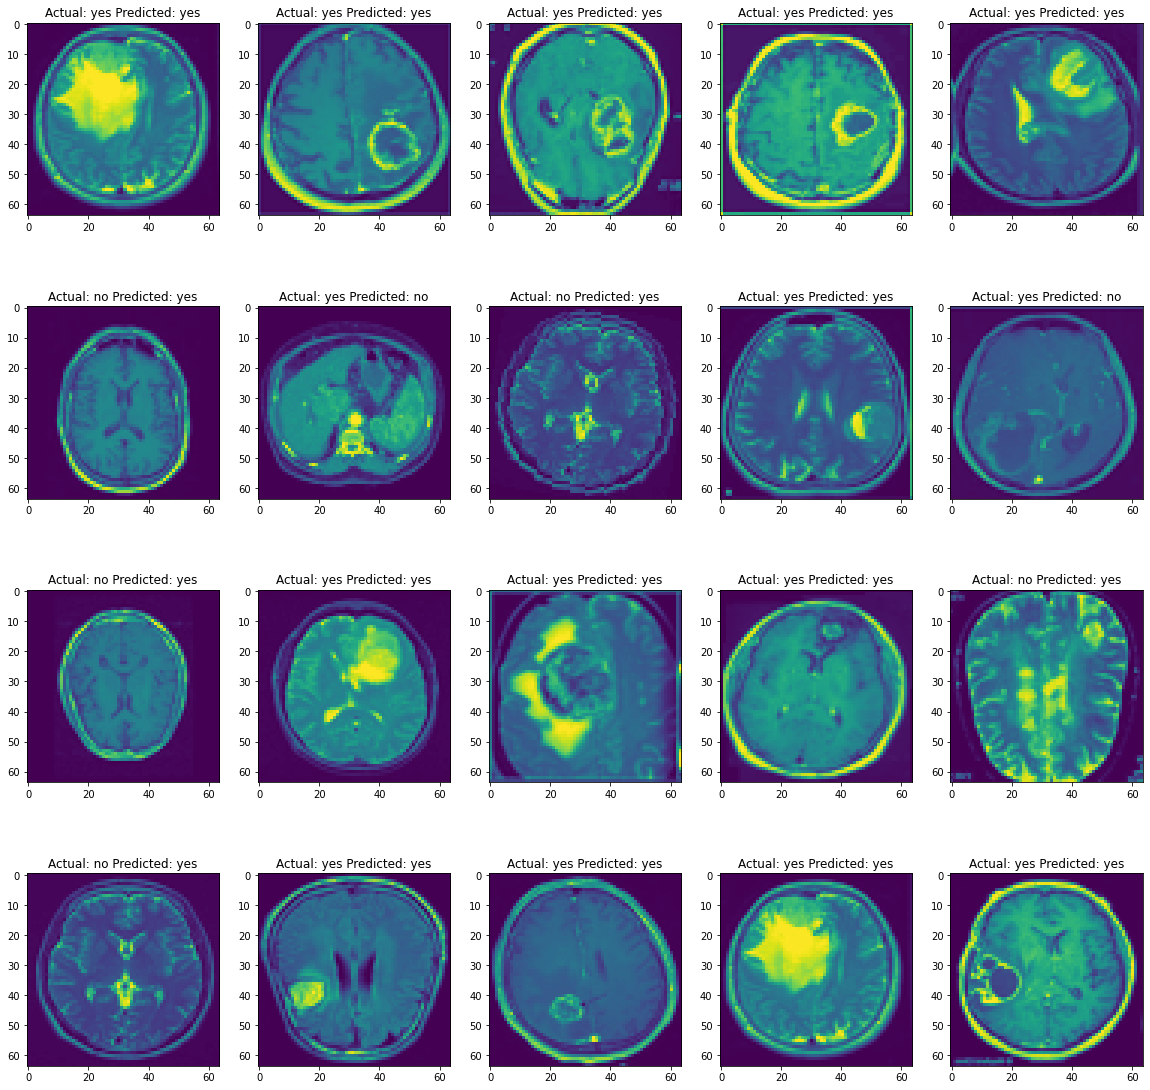

actual accuracy:  0.65


In [10]:
plot_loader = DataLoader(test_data, batch_size=1)

mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
i = 0
correct = 0
raw_predictions = []
for img, lbl in plot_loader:
    if i == 20: break
    print(img.shape)
    pred = model(img.float())

    pred = torch.argmax(pred,dim=1)
    raw_predictions.append(pred)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0].cpu())
    if lbl == pred: correct += 1
    plt.title(f'Actual: {mapping[lbl.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
    i+=1
plt.show()
print(f"actual accuracy: {correct/i: .2f}")

In [17]:
raw_predictions

[tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([1]),
 tensor([0]),
 tensor([1]),
 tensor([1])]

### SyMPC part


In [12]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon

In [13]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    image_pointers = []

#     split_size = int(len(data)/len(session.parties))+1
    split_size = int(len(data)/len(session.parties))


    for index in range(0,len(session.parties)):
#         ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        ptr=data[index*split_size:index*split_size+split_size]
        image_pointers.append(MPCTensor(secret=ptr, session=session))

    return image_pointers

In [14]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)



In [20]:
# default split data
ptrs = []
labels = []
for i, (img, lbl) in enumerate(plot_loader):
    if i == 1: break
    img_f = img.type(torch.float32)
    print(img.shape)
    # ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    # labels.append(lbl)
len(ptrs)



torch.Size([1, 1, 64, 64])


<ipython-input-2-8fce9ac9f1d5>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


0

In [20]:
mpc_model = model.share(session)
mpc_model

In [21]:
#Perform inference and measure time taken
import time
start_time = time.time()

results = []

for ptr in ptrs:
    encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {encrypted_results}")
    plaintext_results = encrypted_results.reconstruct()
    print(f"plain text results: {plaintext_results}")
    results.append(plaintext_results)

end_time = time.time()
results

[2022-02-28T22:44:05.646540+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 83ba65c33fe94d66baea1b93d47ebfc5>.
[2022-02-28T22:44:05.649566+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0091ff19a54b4e398015418d77ddc6fb>.
[2022-02-28T22:45:17.129922+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 85b81716d7b440e890935a04f6a0e872>.
[2022-02-28T22:45:17.133888+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a1c9b802dd814efaaa26da1f11fd5656>.
[2022-02-28T22:45:49.178674+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b380c034006642f1b4876fa4ee5fb5e2>.
[2022-02-28T22:45:49.181675+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c44a8fce24074a1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.6424, -2.7201]])


[2022-02-28T22:45:56.356831+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97c70079d6c04830a3ab90f557dcb5bf>.
[2022-02-28T22:45:56.361072+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cba001c7f11342ee959b8e509a1e739f>.
[2022-02-28T22:45:56.373905+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e0850f403b9648e58c8e5726c5788eaa>.
[2022-02-28T22:45:56.379831+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42616e52df56430f8e3ecedfc5b2915c>.
[2022-02-28T22:45:56.387831+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e96daf52dec743fca6ffb2cb3c8a7b74>.
[2022-02-28T22:45:56.389832+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1412734c0bfb447

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-23.1638,  24.7547]])


[2022-02-28T22:47:43.665421+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd05010258064f9eb63aad866cb4bc46>.
[2022-02-28T22:47:43.668112+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c64016a6089477cae613f93a275c169>.
[2022-02-28T22:47:43.673142+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4140efdd99549c78aa7d00a6c8da28b>.
[2022-02-28T22:47:43.676163+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a8656cd22614b0f9226e91474854a78>.
[2022-02-28T22:47:43.826268+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 158d6eca732b4cc2b41a5169a02af944>.
[2022-02-28T22:47:43.829114+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6dbff0cffafd41a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.1036, -1.1894]])


[2022-02-28T22:49:27.933448+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: edcbfe177cf64abea5358632ab4a6b58>.
[2022-02-28T22:49:27.935451+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3cce5c6e6c4c4f96a329652337fabb57>.
[2022-02-28T22:49:27.942419+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9bd115b99afb4ec380dfbf3ab8f31456>.
[2022-02-28T22:49:27.944441+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 875175f6a8db491fba0de459acab5585>.
[2022-02-28T22:49:27.953448+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 08784465f1ea419fa5d0c1f5d4dd0cc4>.
[2022-02-28T22:49:27.956419+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90f3c77df0fa4e9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.4655,  1.4684]])


[2022-02-28T22:51:11.698075+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d9081241e6434d8fbd0d02d5977aac26>.
[2022-02-28T22:51:11.701190+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c2064f17290c4dcfb7e8ef423704831e>.
[2022-02-28T22:51:11.708076+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b220427068b040148ca4539514785763>.
[2022-02-28T22:51:11.712080+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1750d4a74411419693a8b11fb0c75232>.
[2022-02-28T22:51:11.722172+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7bacdf8458446e7b885cb2589e52e1f>.
[2022-02-28T22:51:11.725045+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31a8ba756cd84ea

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.3837,  2.3713]])


[2022-02-28T22:52:54.711371+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 086daf3d49f94af2bf93a917b9b0207f>.
[2022-02-28T22:52:54.714433+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e356389cb0b4193b7cc5382f29c9c64>.
[2022-02-28T22:52:54.723371+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b649ec4a3b5140dd86ce4d5fdd083290>.
[2022-02-28T22:52:54.726399+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a8d2d6131cac47faa1c1286200f01e2b>.
[2022-02-28T22:52:54.732371+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0040c8a22ca44ee894fc3cefc9fbadda>.
[2022-02-28T22:52:54.735385+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1f98143a10df43d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-32.0023,  34.4050]])


[2022-02-28T22:54:38.329831+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 62b7fd281a2e45578e1b9f040e990e50>.
[2022-02-28T22:54:38.332183+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a5444deb7bc04054a89a9886e7713f82>.
[2022-02-28T22:54:38.337971+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 221a8e2d7bc94b289cb691d862d5ab02>.
[2022-02-28T22:54:38.340828+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79af3be72264442a873faa8eb593006f>.
[2022-02-28T22:54:38.348827+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a6b7522b47bd49579638af59cf19654a>.
[2022-02-28T22:54:38.351828+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4024de7702ad484

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.5407,  1.4975]])


[2022-02-28T22:56:21.790828+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: adb9e55bfd4449db9bc4026ba3346f3d>.
[2022-02-28T22:56:21.794105+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea531d53c2f74b6fb56e1109a9687117>.
[2022-02-28T22:56:21.800098+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ed845a821d534c87ada59f5cea2b63de>.
[2022-02-28T22:56:21.803097+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e875d69629944e60bad17094daf01b32>.
[2022-02-28T22:56:21.813096+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 026567bbfad74fa6a507ca5afd5926a5>.
[2022-02-28T22:56:21.817098+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7dae0ab4fda488

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-3.2564, -0.1950]])


[2022-02-28T22:58:04.836421+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b8224c71f4d84e4c8ce99740a4da1d7f>.
[2022-02-28T22:58:04.838497+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17d0f0527a064ffe9f5156085f41594c>.
[2022-02-28T22:58:04.848421+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 977102e6e5344228ad2993a2458166ee>.
[2022-02-28T22:58:04.851993+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f6ed59d797ec4cfbb3fee7c852611bc4>.
[2022-02-28T22:58:04.857844+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ec3adb8a4db409293e54cfd8f571d85>.
[2022-02-28T22:58:04.861420+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d6cd359bda2423

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1567, -0.1967]])


[2022-02-28T22:59:47.878020+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b215b85c71f440cb900fa82e8dcc2c6a>.
[2022-02-28T22:59:47.880989+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 552d3756ab2e4ac28e38608f02808a51>.
[2022-02-28T22:59:47.888988+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f99909ddf47444399cdb1657288550d0>.
[2022-02-28T22:59:47.892234+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 778c8d7d63264040a8312c9d9a8b20ac>.
[2022-02-28T22:59:47.901018+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c798fdc88b04290b577d8f2713aa040>.
[2022-02-28T22:59:47.903994+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d02894fc62bd4dd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-45.1939,  51.8585]])


[2022-02-28T23:01:31.009200+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7077676110dc49759c07811a1f0f9b75>.
[2022-02-28T23:01:31.013046+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a8cff121e61943bfa9fea4dadee43b90>.
[2022-02-28T23:01:31.018044+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18618a52b936405697404064e6570eb2>.
[2022-02-28T23:01:31.021043+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d8279acfca904d8dbdd24b5bded1747f>.
[2022-02-28T23:01:31.185176+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b6ef39dbcd54ea281d541f6ed2dd0aa>.
[2022-02-28T23:01:31.188044+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9961587f434d4c2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-56.8774,  58.8420]])


[2022-02-28T23:03:14.113879+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b0c791711054f94bbb722de48c6633f>.
[2022-02-28T23:03:14.116874+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0e12878594184fad85da871988606730>.
[2022-02-28T23:03:14.124207+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5fa54120bd34c66b0927062441d17c1>.
[2022-02-28T23:03:14.127366+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c590af5100a44dc9ded83954b407bc7>.
[2022-02-28T23:03:14.136874+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ddffe7b62f4b4e3383aa39c6fa441c7c>.
[2022-02-28T23:03:14.139845+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fdfe6f6372d5410

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-36.0167,  36.2405]])


[2022-02-28T23:04:57.371595+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c47b5c33dbbc4b9e94b3433dc842b5f6>.
[2022-02-28T23:04:57.374594+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cce1467db5bb48518860ec93bb1869ce>.
[2022-02-28T23:04:57.379595+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c3f522c348e48948de06f8db833488d>.
[2022-02-28T23:04:57.382594+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7caef20cbe7f45b8bfe15e65b091b2cb>.
[2022-02-28T23:06:00.383717+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bc0385dfd6ed4c3fb7a4d688a339ce92>.
[2022-02-28T23:06:00.387081+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c2b1bd3c3a4487

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-21.9342,  20.7472]])


[2022-02-28T23:06:41.238996+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a17abba8a3104465890d78497d14366f>.
[2022-02-28T23:06:41.242000+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ad2330bfc214e02afe7a6a4d70e7bc3>.
[2022-02-28T23:06:41.247027+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5d66f4a3b8a4f93aa7b048f7058b41a>.
[2022-02-28T23:06:41.250997+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 311e800c64724ce8ae20cb04a8d1d0c6>.
[2022-02-28T23:06:41.259027+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5bf69cc825c5459a85d230ca9e0074ec>.
[2022-02-28T23:06:41.261997+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 51899507c70b4b3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3306, -0.3477]])


[2022-02-28T23:08:24.310220+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a365bd000db94dee9641f834048ef0c6>.
[2022-02-28T23:08:24.313403+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2019aea4fc6a4aeea7b0ee379fd5ca8d>.
[2022-02-28T23:09:39.471001+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b300d7ce39441afbfc5ece53b8e9355>.
[2022-02-28T23:09:39.473048+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4ecfda890cb4ed699e64da3b97c1427>.
[2022-02-28T23:10:19.577505+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f5542d7849244eab81d20d8f36d45753>.
[2022-02-28T23:10:19.581342+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92590acfa01a42e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.1212, -1.5777]])


[2022-02-28T23:10:32.898413+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cfee949eee354045987aac13a2af569c>.
[2022-02-28T23:10:32.904423+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b753f587cf7d47b9bee693f8a7f3d283>.
[2022-02-28T23:10:32.910082+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dbdcc1cf5a6e463780aa4ee1d87bdd2a>.
[2022-02-28T23:10:32.913028+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3c1f515406046fe9407b7877c3df45b>.
[2022-02-28T23:10:33.196290+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a15d26247df4826967dfe7a75ce1ca6>.
[2022-02-28T23:10:33.199973+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b663acf55f70494

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2033,  0.2193]])


[2022-02-28T23:12:46.724233+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b134193711664130a48c82790bc7fa03>.
[2022-02-28T23:12:46.727200+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b74db9eb16d4105828e05f522194e14>.
[2022-02-28T23:12:46.733067+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bbdbfaeced8c4678b087f666b70c5abb>.
[2022-02-28T23:12:46.741201+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 35c5e377761544bc888c97bb087a623b>.
[2022-02-28T23:12:46.755705+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ceff04653f4d491c91aa64cdd4831939>.
[2022-02-28T23:12:46.761213+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: df8615404e754f5

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1728, -0.1134]])


[2022-02-28T23:15:00.608953+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f52293eeac6463eb584b43dde3b3559>.
[2022-02-28T23:15:00.611395+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: edf875872e0a4ae1bd95d5c1e7c51731>.
[2022-02-28T23:15:00.616968+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0462efb5aa4b43aebe934024798b35c9>.
[2022-02-28T23:15:00.622565+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a15e8afbd094227957efe75c20d78c6>.
[2022-02-28T23:15:00.819041+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 605773710e5e49ce81a87fec725ebc46>.
[2022-02-28T23:15:00.829050+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4dd557127884f2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2047, -0.2181]])


[2022-02-28T23:17:09.194198+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c1b24ca28034b4ab17f3b17af14077c>.
[2022-02-28T23:17:09.197794+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc5cf3228fd04127843955278e6aaf7e>.
[2022-02-28T23:17:09.205470+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b1cc1ba387e2403e828485d00af65a33>.
[2022-02-28T23:17:09.207808+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58e313b7153d4ad38da3f781969fac51>.
[2022-02-28T23:17:09.218831+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0214823045a0421b822be524bc97c6a7>.
[2022-02-28T23:17:09.222795+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c25a4d5b84940e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7380,  0.7810]])


[2022-02-28T23:18:52.575586+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da9da7cb7ecb4e858b3136aa72c6de1b>.
[2022-02-28T23:18:52.578555+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6be7cfedaaca4a868616d5a4bab75f3f>.
[2022-02-28T23:18:52.584844+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 608e274ab2434a3b8417c7e34d59b7a6>.
[2022-02-28T23:18:52.588556+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0966b16778444fa0b05ff928b3f69179>.
[2022-02-28T23:18:52.597591+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ef63fbbde7b49b994687020cd64c039>.
[2022-02-28T23:18:52.600554+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a0c2dd0004a416

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 14.6301, -21.1845]])


[tensor([[ 2.6424, -2.7201]]),
 tensor([[-23.1638,  24.7547]]),
 tensor([[ 1.1036, -1.1894]]),
 tensor([[-1.4655,  1.4684]]),
 tensor([[-2.3837,  2.3713]]),
 tensor([[-32.0023,  34.4050]]),
 tensor([[-1.5407,  1.4975]]),
 tensor([[-3.2564, -0.1950]]),
 tensor([[ 0.1567, -0.1967]]),
 tensor([[-45.1939,  51.8585]]),
 tensor([[-56.8774,  58.8420]]),
 tensor([[-36.0167,  36.2405]]),
 tensor([[-21.9342,  20.7472]]),
 tensor([[ 0.3306, -0.3477]]),
 tensor([[ 3.1212, -1.5777]]),
 tensor([[-0.2033,  0.2193]]),
 tensor([[ 0.1728, -0.1134]]),
 tensor([[ 0.2047, -0.2181]]),
 tensor([[-0.7380,  0.7810]]),
 tensor([[ 14.6301, -21.1845]])]

<ipython-input-2-2ae5f95b70be>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)
[2022-02-28T23:20:30.644202+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 608f61e60f43499186a828e882dce350>.
[2022-02-28T23:20:30.646346+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d631c957780d48f09ed4f4248828646c>.
[2022-02-28T23:20:30.656203+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d01b8d131b844b48b0e22b1a71c870a5>.
[2022-02-28T23:20:30.658204+0100][CRITICAL][logger]][20604] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3356c7c40b5b46b09402ee9f5681536f>.


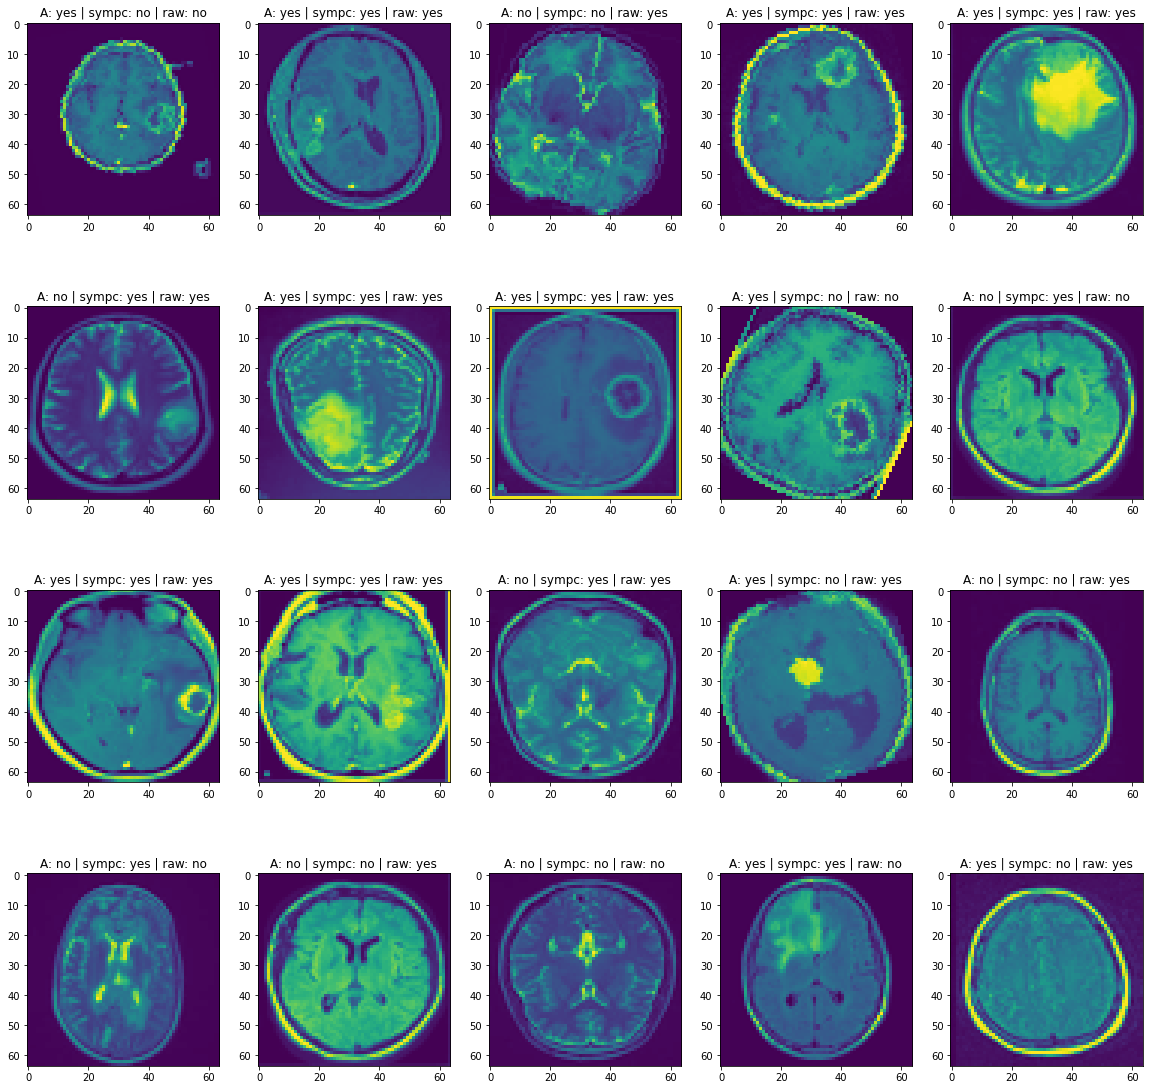

Time for inference: 2189.6605117321014
Succes rate (sympc pred/actual labels):  0.63
Succes rate (sympc pred/raw pred):  0.63


In [22]:
fig = plt.figure(figsize=(20,20))
iter_loader = iter(plot_loader)
succes_sympc_overal = 0
succes_sympc_raw = 0
for i in range(20):
    img, label = next(iter_loader)
    pred = results[i]
    raw_pred = raw_predictions[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0])
    plt.title(f"A: {mapping[target.detach().item()]} | " +
              f"sympc: {mapping[pred.detach().item()]} | " +
              f"raw: {mapping[raw_pred.detach().item()]}")
    if pred == label: succes_sympc_overal += 1
    if pred == raw_pred: succes_sympc_raw += 1
    
plt.show()
print(f"Time for inference: {end_time - start_time}")
print(f"Succes rate (sympc pred/actual labels): {succes_sympc_overal/i: .2f}")
print(f"Succes rate (sympc pred/raw pred): {succes_sympc_raw/i: .2f}")